<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/Bayesian_CNN_implementation_reproduction_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1672 (delta 66), reused 80 (delta 43), pack-reused 1561
Receiving objects: 100% (1672/1672), 67.82 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.


In [ ]:
import os
os.chdir('/content/PyTorch-BayesianCNN/')
os.getcwd()

'/content/PyTorch-BayesianCNN'

#Main

In [ ]:
from __future__ import print_function

import os
import argparse

import torch
import numpy as np
from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F

import data
import utils
import metrics
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')


def train_model(net, optimizer, criterion, trainloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    for i, (inputs, labels) in enumerate(trainloader, 1):

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
        
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(trainloader), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(metrics.acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list)


def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(validloader), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)


dataset, net_type = 'MNIST', 'alexnet'

# Hyper Parameter settings
layer_type = cfg.layer_type
activation_type = cfg.activation_type
priors = cfg.priors

train_ens = cfg.train_ens
valid_ens = cfg.valid_ens
n_epochs = 100#cfg.n_epochs
lr_start = cfg.lr_start
num_workers = cfg.num_workers
valid_size = cfg.valid_size
batch_size = cfg.batch_size
beta_type = cfg.beta_type

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(
    trainset, testset, valid_size, batch_size, num_workers)
net = getModel(net_type, inputs, outputs, priors, layer_type, activation_type).to(device)

ckpt_dir = f'checkpoints/{dataset}/bayesian'
ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir, exist_ok=True)

criterion = metrics.ELBO(len(trainset)).to(device)
optimizer = Adam(net.parameters(), lr=lr_start)
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
valid_loss_max = np.Inf

for epoch in range(n_epochs):  # loop over the dataset multiple times

    train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    lr_sched.step(valid_loss)
    print('_____________________________________________________________________________________________________________________________________________________')
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
        epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

    # save model if validation accuracy has increased
    if valid_loss <= valid_loss_max:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_max, valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_max = valid_loss


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


"\nfor epoch in range(n_epochs):  # loop over the dataset multiple times\n\n    train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)\n    valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)\n    lr_sched.step(valid_loss)\n    print('_____________________________________________________________________________________________________________________________________________________')\n    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(\n        epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))\n\n    # save model if validation accuracy has increased\n    if valid_loss <= valid_loss_max:\n        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.form

In [ ]:
net(torch.randn(1,1,64,64).to(device))[0].size()

torch.Size([4, 10])

In [ ]:
import matplotlib.pyplot as plt
net.train()
for inputs, outputs in valid_loader:
    inputs, outputs = inputs.to(device), outputs.to(device)

    img, label = inputs[0], outputs[0] #single image and label
    pred = torch.zeros(50, 10)
    for k in range(50):
        out, kl = net(img.unsqueeze(0))
        pred[k, :] = out
        plt.plot(out[0].detach().cpu().numpy())
    plt.show()
    #print(pred)
    break


In [ ]:
pred.size()

torch.Size([50, 10])

In [ ]:
net.conv2.W_mu.size()

torch.Size([192, 64, 5, 5])

#Prediction

In [ ]:
import argparse
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torchvision
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import data
from main_bayesian import getModel
import config_bayesian as cfg


# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mnist_set = None
notmnist_set = None

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def init_dataset(notmnist_dir):
    global mnist_set
    global notmnist_set
    mnist_set, _, _, _ = data.getDataset('MNIST')
    notmnist_set = torchvision.datasets.ImageFolder(root=notmnist_dir)


def get_uncertainty_per_image(model, input_image, T=15, normalized=False):
    input_image = input_image.unsqueeze(0)
    input_images = input_image.repeat(T, 1, 1, 1)

    net_out, _ = model(input_images)
    pred = torch.mean(net_out, dim=0).cpu().detach().numpy()
    if normalized:
        prediction = F.softplus(net_out)
        p_hat = prediction / torch.sum(prediction, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(net_out, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)

    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic = np.dot(temp.T, temp) / T
    epistemic = np.diag(epistemic)

    aleatoric = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric = np.diag(aleatoric)

    return pred, epistemic, aleatoric


def get_sample(dataset, sample_type='mnist'):
    idx = np.random.randint(len(dataset.targets))
    if sample_type=='mnist':
        sample = dataset.data[idx]
        truth = dataset.targets[idx]
    else:
        path, truth = dataset.samples[idx]
        sample = torch.from_numpy(np.array(Image.open(path)))

    sample = sample.unsqueeze(0)
    sample = transform(sample)
    return sample.to(device), truth


def run(net_type, weight_path, notmnist_dir):
    init_dataset(notmnist_dir)

    layer_type = cfg.layer_type
    activation_type = cfg.activation_type

    net = getModel(net_type, 1, 10, priors=None, layer_type=layer_type, activation_type=activation_type)
    net.load_state_dict(torch.load(weight_path))
    net.train()
    net.to(device)

    fig = plt.figure()
    fig.suptitle('Uncertainty Estimation', fontsize='x-large')
    mnist_img = fig.add_subplot(321)
    notmnist_img = fig.add_subplot(322)
    epi_stats_norm = fig.add_subplot(323)
    ale_stats_norm = fig.add_subplot(324)
    epi_stats_soft = fig.add_subplot(325)
    ale_stats_soft = fig.add_subplot(326)

    sample_mnist, truth_mnist = get_sample(mnist_set)
    pred_mnist, epi_mnist_norm, ale_mnist_norm = get_uncertainty_per_image(net, sample_mnist, T=25, normalized=True)
    pred_mnist, epi_mnist_soft, ale_mnist_soft = get_uncertainty_per_image(net, sample_mnist, T=25, normalized=False)
    mnist_img.imshow(sample_mnist.squeeze().cpu(), cmap='gray')
    mnist_img.axis('off')
    mnist_img.set_title('MNIST Truth: {} Prediction: {}'.format(int(truth_mnist), int(np.argmax(pred_mnist))))

    sample_notmnist, truth_notmnist = get_sample(notmnist_set, sample_type='notmnist')
    pred_notmnist, epi_notmnist_norm, ale_notmnist_norm = get_uncertainty_per_image(net, sample_notmnist, T=25, normalized=True)
    pred_notmnist, epi_notmnist_soft, ale_notmnist_soft = get_uncertainty_per_image(net, sample_notmnist, T=25, normalized=False)
    notmnist_img.imshow(sample_notmnist.squeeze().cpu(), cmap='gray')
    notmnist_img.axis('off')
    notmnist_img.set_title('notMNIST Truth: {}({}) Prediction: {}({})'.format(
        int(truth_notmnist), chr(65 + truth_notmnist), int(np.argmax(pred_notmnist)), chr(65 + np.argmax(pred_notmnist))))

    x = list(range(10))
    data = pd.DataFrame({
        'epistemic_norm': np.hstack([epi_mnist_norm, epi_notmnist_norm]),
        'aleatoric_norm': np.hstack([ale_mnist_norm, ale_notmnist_norm]),
        'epistemic_soft': np.hstack([epi_mnist_soft, epi_notmnist_soft]),
        'aleatoric_soft': np.hstack([ale_mnist_soft, ale_notmnist_soft]),
        'category': np.hstack([x, x]),
        'dataset': np.hstack([['MNIST']*10, ['notMNIST']*10])
    })
    print(data)
    sns.barplot(x='category', y='epistemic_norm', hue='dataset', data=data, ax=epi_stats_norm)
    sns.barplot(x='category', y='aleatoric_norm', hue='dataset', data=data, ax=ale_stats_norm)
    epi_stats_norm.set_title('Epistemic Uncertainty (Normalized)')
    ale_stats_norm.set_title('Aleatoric Uncertainty (Normalized)')

    sns.barplot(x='category', y='epistemic_soft', hue='dataset', data=data, ax=epi_stats_soft)
    sns.barplot(x='category', y='aleatoric_soft', hue='dataset', data=data, ax=ale_stats_soft)
    epi_stats_soft.set_title('Epistemic Uncertainty (Softmax)')
    ale_stats_soft.set_title('Aleatoric Uncertainty (Softmax)')

    plt.show()


#if __name__ == '__main__':
#   parser = argparse.ArgumentParser(description = "PyTorch Uncertainty Estimation b/w MNIST and notMNIST")
#    parser.add_argument('--net_type', default='lenet', type=str, help='model')
#    parser.add_argument('--weights_path', default='checkpoints/MNIST/bayesian/model_lenet.pt', type=str, help='weights for model')
#    parser.add_argument('--notmnist_dir', default='data/notMNIST_small/', type=str, help='weights for model')
#    args = parser.parse_args()

#    run(args.net_type, args.weights_path, args.notmnist_dir)

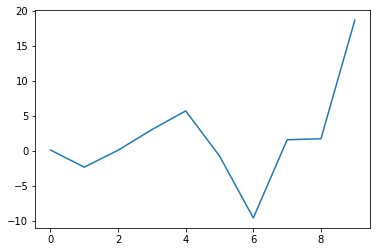

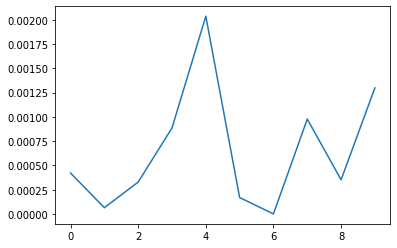

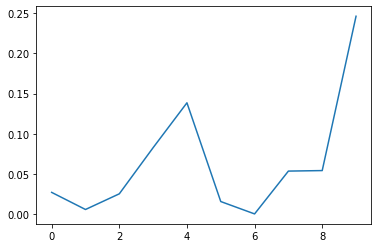

In [ ]:
pred_mnist, epi_mnist_norm, ale_mnist_norm = get_uncertainty_per_image(net, img, T=25, normalized=True)
plt.plot(pred_mnist)
plt.show()
plt.plot(epi_mnist_norm)
plt.show()
plt.plot(ale_mnist_norm)
plt.show()